# **Sequence to Sequence (Seq2Seq) Models - Tradutor Inglês para Português**

- Neste notebook vamos criar um algoritmo capaz de traduzir sentenças do Inglês para o Português.

In [ ]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Sequence-to-Sequence (Seq2Seq) Models**

Suponha que estejamos construindo uma rede neural para tradução de textos.
- A tradução poderá conter um número de palavras (ou número de caracteres) diferente do total de palavras do texto de input:

"I am learning English" - 4 palavras;

"Sto imparando inglese" - 3 palavras;

"Estou aprendendo inglês" - 3 palavras.

- Em uma RNN padrão, tomar as saídas em cada ponto no tempo resultará em uma saída sempre do mesmo tamanho que a entrada.
- A solução para este problema é a arquitetura Seq2Seq.


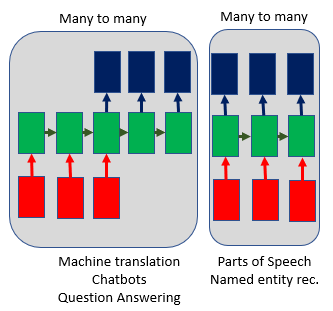

A arquitetura Seq2Seq é um duplo sistema de RNNs.
- O primeiro sistema processa os inputs. Ele é chamado de "**Encoder**".
- O segundo sistema produz a tradução (ou a resposta a uma dada pergunta, no caso de um chatbot ou assistente de consultas). Ele é chamado de "**Decoder**".

Basicamente, é a mesma ideia geral vista em diversas aplicações do deep learning: tomamos uma entrada bruta ("raw input"), a qual pode ser um texto, som, ou imagem, **e criamos um vetor que representa este dado numericamente**. A criação da representação numérica da sequência de palavras é feita pelo primeiro sistema (encoder).
- Note que o vetor resultante é uma **representação comprimida ("compressed data") do texto de entrada**.

O decoder (2º sistema) utiliza esta representação comprimida para gerar novos dados (correspondentes à tradução ou à resposta).
- Assim, o decoder "descomprime" os dados, mas em uma nova forma adequada à saída desejada (um outro idioma, por exemplo).

A aplicação mais básica e imediata deste algoritmo é um sistema de tradução automática ("auto-encoder") de texto escrito ou de som reproduzido.

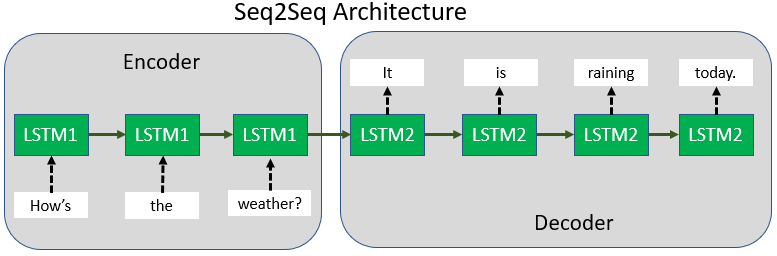

# **Funcionamento do Encoder**

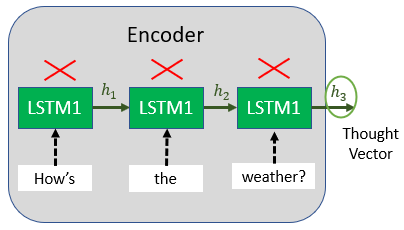

- Este sistema funciona como uma RNN padrão, na qual temos unidades recursivas LSTM ou GRU.
- É fornecida uma sequência de entrada (inputs), e **é retornada uma série de valores de hidden states h**.
- Não existem saídas (outputs), pois este primeiro sistema não realiza previsões.

IMPORTANTE: No **primeiro sistema RNN, desejamos manter somente o estado final hₜ (e o correspondente cell state cₜ**, caso estejamos utilizando o LSTM).
- No diagrama acima, são mostrados apenas os estados h para manter a simplicidade (os estados c que deixam as unidades são omitidos para não poluir a imagem).

Em Keras, isto implica utilizar o argumento:

```
return_sequences = False
```
Assim, a saída do primeiro sistema será hₜ, um vetor de dimensão M.
- De toda a sequência de entrada, **o que deixa o Encoder é apenas um vetor de comprimento estático M**.
- Você pode entender este vetor de saída como um **vetor de pensamentos ("thought vector")**.
- Este vetor não contém nenhuma informação temporal, mas representa toda a sequência de input.

Por esta razão, a saída é dita um encoding: uma representação compacta da entrada original.
- Outra forma de entender o processo encoding-decoding é imaginar a informação original como uma folha de papel contendo uma carta ou mensagem codificada a ser enviada a um receptor.
- O encoder dobra a folha em uma forma mais compacta, para que ela seja transportada até o receptor.
- No decoding, o receptor desdobra e decodifica a mensagem, possibilitando a sua interpretação.


# **Funcionamento do Decoder**

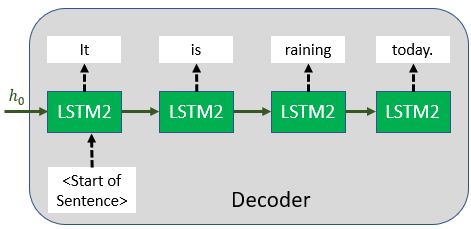

- A primeira unidade RNN do Decoder possui seus próprios pesos, independentes dos pesos do primeiro sistema (encoder).
- A unidade RNN deve apresentar a mesma dimensão vetorial M, já que o input deste novo sistema (hₒ) é o vetor de pensamentos hₜ obtido como saída do Encoder.
- Além disso, é fornecido um token `<Start of Sentence>` ao input x da RNN. Este token informa o ponto no qual a nova sequência textual é iniciada.
- Tipicamente, este token é fornecido ao início da sentença e é demarcado pelas tags < e > ("angle brackets") - Devemos nos lembrar de adicionar os tokens ao dataset de treinamento.

A RNN utilizará o valor hₒ para calcular h1. Com h1, é possível calcular y1.
- **y1 será um vetor de probabilidades, a partir do qual podemos obter um valor de máxima probabilidade. Este valor máximo será correspondente à palavra ou expressão com maior probabilidade de corresponder à tradução para a língua desejada** ("target language").

# **Como prever a tradução da segunda, terceira, etc. palavra?**

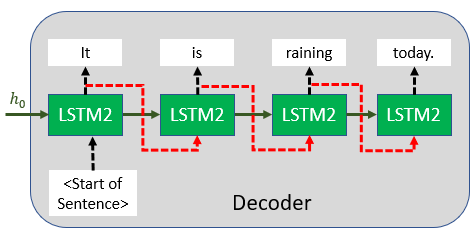

A palavra yi calculada anteriormente é passada como input xi+1 da RNN seguinte.
- Assim, a saída y1 da primeira RNN é usada como entrada x2 da RNN seguinte;
- Analogamente, a saída y2 da segunda RNN será a entrada x3 da RNN seguinte.

NOTA: acrescentamos uma ou mais camadas densas ("dense layers") após a saída da última LSTM.

# **Trabalho com sequências de tamanho constante**

- A princípio, este não parece ser um problema, mas repare novamente na figura:

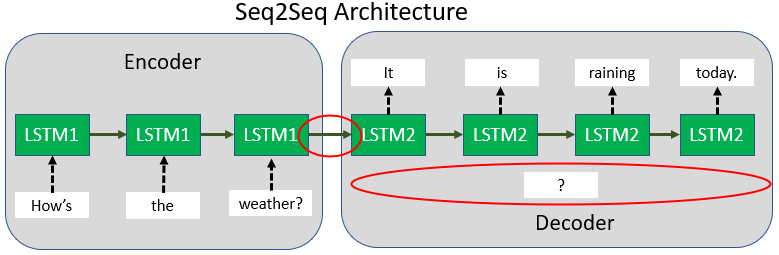

# **Teacher forcing**

Lembre-se que, **considerando os hidden states prévios como alimentação, cada RNN possui 2 inputs e ao menos uma saída**.
- Quando alimentamos o sistema Encoder-Decoder com a sequência de palavras a ser traduzida, as saídas das RNNs do sistema de encoding são, na realidade, ignoradas. **Isso porque queremos apenas o último hidden state do sistema de encoding**.
- Já no **sistema de decoding, nós tomamos as saídas e comparamos com os elementos da sequência "target"**. No caso de "machine translation", isto consiste simplesmente na sequência de input traduzida para um determinado idioma.

Observando novamente a imagem acima, repare que, no primeiro sistema (encoding), as RNNs apresentam 2 inputs: a sequência de palavras a serem traduzidas e o hidden state prévio.
- O que existe então na parte inferior das RNNs do sistema de decoding, destacada na imagem acima como uma interrogação?

Vimos anteriormente neste notebook que podemos usar a saída da unidade RNN como alimentação da unidade RNN seguinte (linhas vermelhas tracejadas).
- Embora esta **metodologia seja boa para realização de previsões**, pesquisadores descobriram que existe uma abordagem que funciona melhor para treinamento: é o chamado "**teacher forcing**".

# **Funcionamento do Teacher Forcing**

- Ao invés de alimentar uma unidade RNN com a saída da unidade anterior, nós **alimentamos cada unidade do decoder com a palavra target verdadeira**.
- Como se trata de dados de treinamento, teremos não só a tradução que o modelo previu (que pode ou não estar certa, já que ele ainda está aprendendo a traduzir), mas também a palavra que de fato deve ser gerada ao fim (a tradução correta, já validada). Esta resposta correta é o target verdadeiro ao qual nos referimos acima.
- Existe um offset correspondente ao token `<Start of Sentence>`.

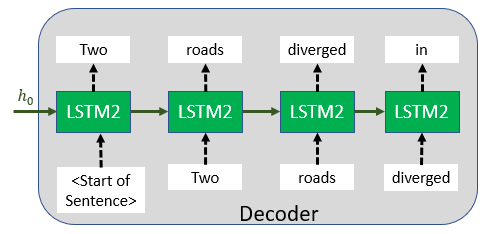

- Mesmo que o modelo não tenha obtido corretamente a palavra anterior, o "teacher forcing" corrige o modelo.
- Assim, **o modelo consegue prever a próxima palavra com base na tradução correta**.

Esta abordagem auxilia o treinamento porque **seria difícil para o modelo gerar a sequência traduzida completa de uma vez só**.
- Esta situação é o que ocorre comumente em aulas de idiomas: se o estudante escreve ou fala equivocadamente uma das palavras, o professor o corrige, e o aluno utiliza esta informação corrigida para finalizar o restante da sentença.
- Se você traduzir erradamente uma palavra e não houver correção, todas as previsões futuras serão de certa forma desperdiçadas, pois a frase inteira contém um erro inicial.

Repare que o offset de uma unidade recorrente associado ao token `<Start of Sentence>` está relacionado ao fato de que estamos sempre tentando prever a palavra seguinte.
- **Se houvesse alinhamento perfeito das palavras, o decoder aprenderia a simplesmente copiar o input no output**, algo sem utilidade.

Como Keras trabalha com sequências de tamanho constante, se o input apresentar comprimento 100, o output também apresentará comprimento igual a 100.
- Suponha que o comprimento das sequências seja Ty. Neste caso, passamos sempre sequências de comprimento Ty durante o treinamento.
- Além disso, no treinamento temos os targets (respostas) verdadeiros para fornecer como input inferior do decoder.
- O problema é que **é impossível ou inviável garantirmos o comprimento constante quando trabalhamos com sequências quaisquer para as quais desejamos prever os resultados.**
- Por consequência, **também é impossível passarmos o target verdadeiro como input, uma vez que desejamos justamente conhecer as respostas**.

### **Assim, para o teste e para a realização de previsões, precisamos voltar à arquitetura original na qual a saída de uma unidade é utilizada como entrada da unidade seguinte (linhas tracejadas vermelhas)**.

- Com isso, o **tamanho das sequências será sempre 1, já que elas serão formadas por palavras ou tokens únicos**.
- Note que isto ocorre porque estamos **utilizando um loop (processo iterativo) que gera uma única palavra por vez** (por ciclo).
- Não é possível fornecer todos os valores Ty de uma vez só, já que estes valores ainda não foram gerados.

# **Resumindo a problemática:**

1) Keras precisa trabalhar com inputs (sequências) de mesmos comprimentos;

2) Ao utilizar "teacher forcing" para o treinamento, o comprimento das sequências de input do decoder é Ty = comprimento da sequência target (target = resposta = sequência traduzida para a língua desejada. **Treinamos a RNN com traduções corretas, as quais já conhecemos e validamos**);

3) Durante o teste, o comprimento das sequências de input do decoder é 1, pois utilizamos uma única palavra por vez (alimentamos uma unidade RNN com a palavra de saída e com o hidden state obtido na unidade anterior).

À primeira vista, a combinação dos problemas 2 e 3 está em desacordo com a questão número 1.

# **Solução: criação de 2 modelos**

Veja o pseudocódigo relacionado abaixo. O primeiro modelo que criamos é destinado apenas ao treinamento:

```
emb = Embedding(); lstm = LSTM(); dense = Dense();
input1 = Input(length = Ty)
model1 = Model(input1, dense(lstm(emb(input1))))
```
O segundo modelo é destinado à amostragem ("sampling"), e nós **utilizamos as camadas de decoding previamente definidas na criação do primeiro modelo**.

```
input2 = Input(length = 1)
model2 = Model(input2, dense(lstm(emb(input2))))
```
Assim, podemos definir um novo conjunto de inputs para o segundo modelo. Estes inputs apresentarão comprimento de sequência igual a 1 (sequências formadas por uma única palavra ou token).
- Note que, de fato, `model1` e `model2` usam as mesmas camadas definidas no início. A única diferença está no input fornecido a tais camadas: `input1` é substituído por `input2`.

O pseudocódigo para a tradução do texto é basicamente um loop `for`.
- Primeiramente, tomamos o hidden state final h do modelo do encoder, e assinalamos este valor como o h inicial do decoder.
- Também assinalamos o token de começo da sequência ao primeiro valor de input x.
- Com isso, podemos obter tanto a previsão da palavra de saída da primeira RNN (output) quanto o hidden state seguinte.
- A seguir, esta saída e o novo hidden state são utilizados como valores de input h e x da próxima unidade RNN, e o loop prossegue da mesma forma.
```
h = encoder model output; x = <Start of Sentence> = <SOS>
for t in range(Ty):
  x, h = model2.predict(x, h)
```
- Nós só conseguimos gerar uma única palavra por vez. Consequentemente, só podemos alimentar as unidades RNN com uma única palavra por vez, fazendo com que as sequências tenham sempre de ser de comprimento unitário.






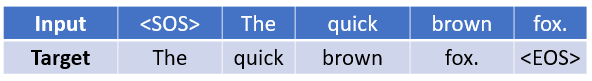

- Na imagem acima, o token `<SOS> =<Start of Sentence>`; enquanto `<EOS> = <End of Sentence>`.
- Note que o método do "teacher forcing" simplesmente calcula a probabilidade de se obter uma palavra em um instante t, dada a palavra obtida no instante t-1 (a palavra de maior probabilidade é a escolhida).
- Para isso, usamos uma sequência de target (resposta esperada = tradução já conhecida) que é simplesmente a sequência de input com um offset de 1 unidade recorrente.
- Note na imagem acima que as duas sequências são de mesmo comprimento.
- Construir o modelo desta forma **ensina a RNN a prever a próxima palavra, dada a palavra anterior em uma sentença**.


# **Exemplos de aplicação** 

## **Geração de poemas ("poetry generation") - Modelagem Linguística**

- A geração de poemas é um caso particular da modelagem linguística ("language modelling").
- As RNNs aprendem um modelo probabilístico a partir de um conjunto de poemas (textos de entrada). A partir daí, o sistema pode gerar novos poemas.
- O esquema anterior de "teacher forcing" permite a geração de poesia após o treinamento das redes neurais.
- **Novas sentenças são geradas a partir da distribuição de probabilidades de se encontrar uma nova palavra**. Basta realizarmos a amostragem ("sampling") da distribuição de probabilidades esperada para a saída da RNN.

A **única diferença entre a modelagem linguística ("language modelling") e o Seq2Seq está na entrada do sistema de decoding**:
- No Seq2Seq, o hidden state inicial no decoder é a saída hₒ do encoder;
- Em language modelling, o hidden state inicial ou é simplesmente um parâmetro arbitrário, ou é definido como sendo igual a zero.

A construção de um código para "language modelling" requer exatamente o mesmo código que a construção de um modelo Seq2Seq.

## **Responder perguntas ("Q&A - Questions and Answering")**

- Dada uma história, a RNN produz uma resposta. É um teste de compreensão da leitura.
- A história (contexto) e a pergunta são concatenadas de modo a formar uma única sequência de input;
- O Encoder converte a sequência de input em um vetor de pensamento ("thought vector");
- **O vetor de pensamentos é decodificado para formar uma resposta**.
- Uma base de dados utilizada aqui é exatamente igual ao Machine Translation Dataset: você possui sequências de palavras como inputs; e uma sequência alvo (target) de palavras. A rede neural é treinada para aprender a relacionar estes pares input-target.

## **Chatbots**

- A base de dados necessária pode ter exatamente o mesmo formato da anterior, utilizada para responder perguntas (Q&A).
- O usuário diz algo ao Chatbot, e ele retorna uma resposta.
- Assim, tanto chatbots quanto Q&A podem utilizar a mesma estrutura `requisição - resposta` que a tradução de textos ("neural machine translation").
- O usuário fornece como input uma sequência de palavras, e a saída (output) será outra sequência de palavras.
- Porém, a arquitetura Seq2Seq não é a melhor para os chatbots: conversas reais envolvem ideias que se espalham em múltiplas perguntas, respostas e afirmações. Este processo retro-alimentativo envolve todos os agentes envolvidos, e pode ocorrer retorno a um determinado tópico muito tempo depois de ele ter sido mencionado.
- Por sua vez, conversas formadas apenas por pares questão-resposta não apresentam fluidez e não são naturais.
- Assim, idealmente, o chatbot deve se lembrar não apenas do que foi dito anteriormente, mas do assunto como um todo.
- **A arquitetura Seq2Seq apenas ensina a memorizar pares pergunta-resposta, mas não ensina a ter uma conversa propriamente dita**.


# **Limitações do Seq2Seq**

- A arquitetura encoder-decoder obriga a realizar o enconding da sentença de input completa, **em um único vetor de baixa dimensão**.
- Como todas as sentenças serão convertidas em um vetor de mesma dimensão (baixa), esta arquitetura pode comprometer o desempenho no processamento de sequências muito longas.

- Estas limitações podem ser superadas por modificações da arquitetura Seq2Seq, tais como: o uso da função Max Pooling para escolha do melhor hidden state (ao invés de simplesmente o último h do sistema de encoding); e do uso de RNNs bidirecionais. Assim, torna-se possível trabalhar com situações mais complexas que a simples tradução de frases.

# **Seq2Seq: Conclusões**

O sistema Seq2Seq permite resolver o problema de mapear uma sequência de input a uma sequência de output com dimensões diferentes.
- O sistema mapeia ou correlaciona uma sequência de comprimento Tₓ a uma segunda sequência de comprimento Ty, onde Tₓ != Ty (!= é o operador booleano "diferente de").
- A segunda sentença de comprimento Ty representa, por exemplo, a resposta ou a tradução da sentença de input.

Dados de tradução de vários idiomas estão disponíveis em:
http://www.manythings.org/anki/
- Todos os dados são iguais, mudando apenas o par `língua inicial - língua traduzida` (E.g. English to Spanish, English to Russian, etc).

# **Roteiro para construção de modelos em Keras**

1) Carregar os dados e convertê-los a um formato adequado para a construção do modelo. **As funções do Pandas são necessárias para converter bases gravadas como CSV ou arquivo Excel em objetos do tipo dataframe**, independente se os dados forem previamente carregados no Google Drive, se foram carregados diretamente no ambiente do Google Colab, ou se foram carregados offline usando uma IDE como o Anaconda.

2) Criar o modelo: aqui, forneceremos ao Keras a estrutura do modelo, por exemplo, tipos e configurações das camadas da rede neural, bem como a sequência das camadas e operações.

3) Treinar o modelo com os dados e avaliar seus resultados.

# **Fazer upload de arquivos a partir de sistema de arquivos local**

<code>files.upload</code> é um comando que retorna um dicionário Python com os arquivos incluídos no upload.
O dicionário é indexado com o nome do arquivo e os valores são os dados enviados por upload.

CONFIGURAR Ambiente do COLAB:
No menu superior, clique sobre a seta ao lado das barras RAM e Disco. No dropdown mostrado, selecione 
**"Ver recursos"**.

No novo menu, utilize a barra de rolagem até chegar ao extremo inferior, e selecione a opção **"Alterar o tipo de ambiente de execução"**.

Por fim, em **"Acelerador de hardware"**, selecione **"GPU"**.

Vamos carregar os arquivos com textos a serem classificados via RNN. Eles estão disponíveis nos links abaixo:

Download the word vectors:
http://nlp.stanford.edu/data/glove.6B.zip


Os arquivos glove.6B possuem vetores de palavras já definidos. Como os arquivos são muito pesados, é melhor carregá-los primeiramente no Google Drive para posteriormente trazê-los ao ambiente do Colab (carregar diretamente no Colab levará tempo excessivo).

# **Google Drive**

É possível acessar os arquivos no Drive de várias maneiras. Por exemplo:
- Montar o Google Drive na máquina virtual do ambiente de execução
- Usar um wrapper ao redor da API, <a href="https://pythonhosted.org/PyDrive/">como o PyDrive</a>
- Usar a <a href="https://developers.google.com/drive/v3/web/about-sdk">API REST nativa</a>



Veja abaixo exemplos de cada um eles.

# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [1]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No menu à esquerda, clique sobre o ícone da pasta ("**Arquivos**"), e localize dentro da nova pasta "drive" a pasta do Google Drive contendo os arquivos desejados (clique na seta para expandir os dropdowns). 

Clique sobre a elipse (3 pontos à direita) do arquivo desejado e selecione a opção "**Copiar caminho**" para copiar os endereços de cada um dos arquivos que serão analisados.

Note que o caminho será diferente para cada usuário do Google Drive.

Endereços:

glove.6B.50d.txt: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.50d.txt"

Dicionário Inglês-Português: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/portuguese_english_dict.txt"

# **Importar bibliotecas para análise**

In [2]:
# # https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# get the data at: http://www.manythings.org/anki/
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

As bibliotecas "os" e "sys" possibilitam ler e fundir (merge) arquivos, como será visto adiante.

**Tokenizer**: transformar uma sentença (uma grande string contendo palavras e pontuação) em uma lista de strings, na qual cada elemento da lista é chamado de token.

Tokenização é um aspecto chave e mandatório do processamento de textos. Os tokens são os blocos de construção do processamento de linguagem natural, utilizados tanto em métodos tradicionais quanto nos mais modernos algoritmos de deep learning.

A tokenização consiste em separar um trecho de texto em unidades menores (tokens), as quais podem ser palavras, caracteres, ou subpalavras. A forma mais comum de formar tokens é a separação por meio da identificação de espaços em branco que demarcam a separação entre as palavras.

Assim, o token geralmente será uma palavra, mas pode ser pontuação, apóstrofe, parte de uma contração, etc, dependendo da estratégia de tokenização aplicada. Portanto, a tokenização pode ser vista como uma estratégia de split de strings.

**pad_sequences**: nós precisamos deste comando porque desejamos que todas as nossas sequências apresentem o mesmo comprimento. Porém, quando carregamos a sequência no ambiente, elas apresentam diferentes comprimentos.

Assim, nós adicionamos o padding para obter uma saída "reta".

# **Configurações das redes neurais e do processamento de texto**

In [3]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 40  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

**`BATCH_SIZE`**: quantos dados são usados em cada forward and backward pass. Se temos 3200 dados e o batch size é 32, ocorrem 100 passagens de 32 dados em cada época.

**MAX_SEQUENCE_LENGTH**: definimos em 100 por se tratarem de comentários de internet. Este parâmetro pode ser modificado: por exemplo, após carregar todos os dados, define-se este parâmetro como sendo igual ao maior comprimento presente. Outra estratégia é verificar o histograma dos comprimentos de comentários para averiguar se o parâmetro escolhido faz sentido.

**MAX_VOCAB_SIZE: tamanho do vocabulário de aprendizagem** (total de palavras do vocabulário). Se houver mais que MAX_VOCAB_SIZE = 20000, o vocabulário será truncado em 20.000 palavras. Experimentos mostraram que um falante de inglês nativo conhece, em média, cerca de 20000 palavras. Embora estes resultados sejam controversos e provavelmente superestimados, este é um valor popularmente adotado para este parâmetro.

**EMBEDDING_DIM**: comprimento de cada vetor de palavras (word vector). Você não pode escolher qualquer comprimento quando trabalhando com modelos pré-treinados. Isto porque os *modelos pré-treinados costumam vir com determinados valores de comprimento de vetor de palavras fixados*. Aqui, usaremos vetores de comprimento 50 ou 100, mas comprimentos iguais a 200 e 300 também estão disponíveis nos arquivos.

### **Um número muito pequeno de amostras (`NUM_SAMPLES`) foi escolhido. Aumentar o valor deste hiperparâmetro pode resultar em maiores precisões, mas também aumenta consideravelmente o tempo necessário para treinar o modelo.**

- O dicionário está organizado de modo que as primeiras linhas são as sentenças mais curtas, e o comprimento das sequências é mais ou menos crescente.
- Assim, quanto maior o índice da linha, maior tende ser a sentença armazenada nela.
- Ao controlar o tamanho da amostra, garantimos que usaremos apenas sentenças menores para o treinamento, excluindo as maiores.
 - Como Keras requer sequências de mesmos comprimentos, a presença de uma sentença exageradamente longa faz com que mesmo as sequências pequenas tenham de ser completadas para alcançar o comprimento da maior sentença.
 - Assim, isto resultaria em aumento significativo do consumo de memória e do custo computacional.

# **Criação das listas que armazenarão as sentenças a serem traduzidas**

Como visto, no treinamento utilizamos a abordagem do Teacher Forcing:
- Temos as sequências (sentenças) de input a serem traduzidas. O início da sentença é assinalado pelo token `<SOS>`.
- As sentenças são armazenadas de forma consecutiva em uma lista, chamada `input_texts`. Assim, cada token `<SOS>` indica o apêndice de um novo elemento a esta lista.
- Para treinarmos o modelo de redes neurais, temos uma série de sentenças para as quais conhecemos a tradução correta (os targets). 
- Criamos, então, uma nova lista, chamada `target_texts`, que armazenará sequencialmente as sentenças traduzidas.
- Repare que as listas `input_texts` e `target_texts` possuem índices correspondentes: a tradução do elemento (sentença) de índice i de `input_texts`, `input_texts[i]`, é o elemento (sentença) de índice i de `target_texts`, `target_texts[i]`.
- A indexação das listas começa em zero. Assim, se a lista possui n elementos, seus índices i são tais que 0 ≤ i ≤ (n-1).

No teacher forcing, os inputs de uma unidade recorrente são: os estados h e c obtidos como saídas da unidade anterior; e os targets (sentenças traduzidas, com tradução validada).
- Assim, ainda que o algoritmo tenha traduzido alguma palavra de forma incorreta, ele utilizará a palavra correta para tentar prever a tradução da palavra seguinte. 
- Com esta correção, o treinamento não é prejudicado caso uma palavra tenha sido prevista de forma equivocada.
- Entretanto, o teacher forcing exige que haja um offset de uma unidade entre a palavra que a unidade irá prever e a palavra target utilizada como input.
- **De outra forma: o input de uma unidade será a palavra que a unidade anterior deveria ter previsto** (ainda que a previsão do algoritmo tenha sido equivocada).
- Sem este offset, ou seja, se a unidade recorrente fosse alimentada exatamente com a palavra target que ela deveria prever, ela seria ensinada a simplesmente copiar o seu input no seu output, algo sem utilidade.
- Assim, criamos a lista `target_texts_inputs` para armazenar as sequências de target com o offset de 1 unidade.

In [4]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# **Carregar dicionário de treinamento: sentenças utilizadas como treinamento e os targets (sentenças traduzidas e com tradução validada).**

Repare que um dos hiperparâmetros definidos anteriormente foi

```
NUM_SAMPLES = 10000
```
Este hiperparâmetro limita o total de sentenças que serão utilizadas para o treinamento do modelo.

1) Criamos um loop que **lê a linha t do dicionário, a partir da sua primeira linha (sentença de índice t = 0)**;

2) Caso o loop verifique que t + 1 superará o limite `NUM_SAMPLES`, o loop é interrompido imediatamente.
- Como a indexação começa em zero e não em 1, o total de sentenças igual a `NUM_SAMPLES` será atingido para a linha de índice `t = (NUM_SAMPLES-1)`.
- Ao se alcançar a primeira linha além deste limite, i.e., a linha `t = NUM_SAMPLES`, o algoritmo calculará t+1 e verificará que, de fato, `t+1 = (NUM_SAMPLES+1) > NUM_SAMPLES`. Com isso, o algoritmo será interrompido antes que alguma ação possa ser executada para amostras além do limite de linhas de treinamento.
 


Veja abaixo como é o arquivo do dicionário. **Trata-se de uma base de dados salva em documento de texto, na qual cada linha representa uma entrada**.
- Em arquivos CSV, as diferentes colunas/atributos/variáveis associadas a uma entrada são separadas por vírgulas.
- Em arquivos txt, as colunas ou são separadas por espaços brancos simples, ou por tabulações.

Neste arquivo, a primeira coluna representa a frase no idioma original (Inglês), enquanto a segunda coluna é o target - a frase no idioma traduzido (Português). 

**As colunas aqui são separadas por tabulações**. Em termos de codificação, temos os seguintes caracteres representando tabulações, quebras de linha, etc:

```
\a is alert/bell
\b is backspace/rubout
\n is newline
\r is carriage return (return to left margin)
\t is tab
```

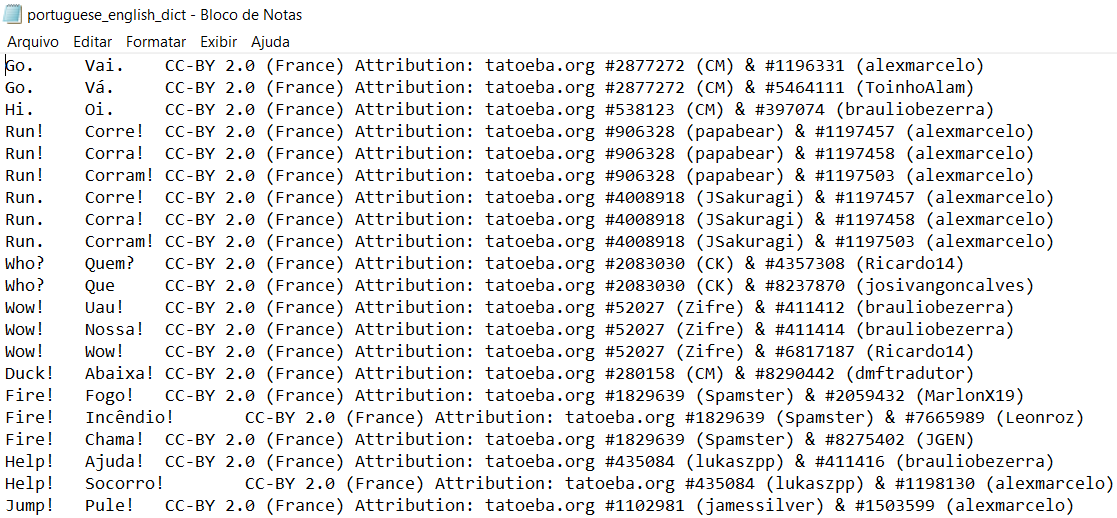

Note que, embora a situação mais comum seja encontrar colunas separadas por vírgulas (CSV) ou por espaçamentos em branco (txt), estes demarcadores não são adequados para este dicionário.

Isso porque o dicionário é composto por frases a serem traduzidas, e as frases já contêm tanto vírgulas quanto espaços em branco.
- Assim, a utilização de tais demarcadores separaria cada frase em múltiplas colunas. 
- Precisamos, portanto, de um demarcador de colunas que não seja encontrado normalmente nas frases, caso da tabulação.

Lembre-se ainda que a tokenização utiliza os espaços em branco da frase para separá-la em tokens (em geral, tokens = palavras, dependendo da estratégia de tokenização).
- A utilização da demarcação incorreta de separação poderia resultar em tokens interpretados como colunas/atributos.

Analisemos, então, o restante do loop:

In [5]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/portuguese_english_dict.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


**ATENÇÃO**

O endereço dos arquivos deve ser inserido com o número correto de espaçamentos. A inclusão de espaços em branco a mais no começo e no fim resultará em erro de processamento.

## **Comando `continue`**

Repare o trecho do código destacado abaixo:

```
  # input and target are separated by tab
  if '\t' not in line:
    continue
```
Este condicional verifica se existe a tabulação separando uma frase de sua tradução.
- Caso esta tabulação não exista, significa que foi realizada uma entrada de uma frase sem a sua correspondente tradução.
- Neste caso, a leitura da sentença faria o algoritmo aprender que a tradução da frase na primeira coluna é uma sentença vazia, o que está errado.
- Assim, para evitar este erro de aprendizado, utilizamos **comando `continue`, que simplesmente avança à próxima iteração sem executar o código restante do loop**.

Desta forma, o comando `continue` faz com que o algoritmo "salte" todas as linhas com entradas sem a correspondente tradução (linhas sem a presença de tabulações separando as colunas). Estas linhas são simplesmente ignoradas no processo de treinamento, de modo que não precisam ser excluídas da base de dados.


# **Método `rstrip()`**

Este método corresponde à função **Trim**, a qual remove as formatações e espaçamentos em branco antes e após uma string ("**trailing spaces**").
- Repare que, uma vez que o tokenizer utiliza os espaços em branco para separar os tokens, a presença destes espaços extras poderia criar uma série de tokens vazios, ou mesmo retornar um erro.

# **Método `split()`**

Este método divide o objeto anterior sempre que encontra a string especificada como argumento.

```
  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')
```
- No caso, o objeto é toda a linha (entrada) após suas três colunas serem submetidas ao método `rstrip()`: `line.rstrip()` (**função Trim**, que elimina espaços extras no começo e ao fim da string).
- Repare que a função Trim é aplicada apenas antes e após todo o texto, de modo que as tabulações delimitadoras de colunas não são apagadas.

Assim, o `split('\t')` separa a linha "trimmed" em cada uma de suas tabulações (string representada pelo caractere especial `'\t'`).

Voltando à imagem anterior que mostra o dicionário, vemos que existem duas tabulações: a primeira separa a sentença do target; e a segunda separa o target da licença de uso.
- Assim, o split separará cada linha em 3 strings: 
 - A primeira é a sentença na língua original, a qual é salva na string `input_text`;
 - A seguinte é a sentença traduzida (target), salva na string `translation`;
 - Por fim, a string `*rest` armazena o restante da linha (licenças de uso), o qual não será utilizado para treinamento do algoritmo.



### **Alternativa ao método `split`**

Por padrão, a função `pandas.read_csv` reconhece a vírgula como separador de coluna. No caso de se fornecer o argumento `delim_whitespace = True`, o espaço em branco simples é reconhecido como separador de coluna. Além disso, o argumento `header=None` informa à função `pandas.read_csv` que o dataframe não possui cabeçalho.
- Alternativamente, é possível fornecer à função `pandas.read_csv` o argumento `sep='\s+'`, o qual informa que o separador de coluna é o espaço branco. Como este argumento é análogo a `delim_whitespace = True`, apenas um dos dois deve ser fornecido.

Assim, ao invés de utilizar o comando `open`, que abre o arquivo como documento de texto simples, poderíamos utilizar a função:

```
pd.read_csv(caminho_do_arquivo, sep='\t', header=None)
```
A qual interpretaria o arquivo como um dataframe sem cabeçalhos e cujas colunas são separadas por tabulação. A seguir, cada coluna seria simplesmente gravada em uma lista diferente.

# **Restante do loop**

Precisamos acrescentar o token de fim da sentença `<eos>` à sequência de target (sentença traduzida).
- Criamos, então, a string target_text, formada pela concatenação da tradução com um espaço em branco e o token `<eos>`.

```
target_text = translation + ' <eos>'
```


Lembrando a **particularidade do teacher forcing**: os inputs de treinamento e os targets devem ser, na realidade, as mesmas sentenças, mas com um offset de 1.
- Este offset é criado pela simples inclusão do token de início da sentença `<sos>` ao começo da frase.

Assim, para criar a string que será utilizada como input da RNN de treinamento, simplesmente concatenamos o token `<sos>` e um espaço em branco ao começo da sentença original. Essa string é chamada `target_text_input`.

```
 target_text_input = '<sos> ' + translation
```

- Para acompanhar o percurso das sentenças de maneira correta, precisamos incluir o token de começo da sentença `<sos>` à sequência de input; e o token de fim da sentença `<eos>` à sequência de target.
- Mais uma vez, note que existe um espaço em branco nas strings:

```
'<sos> '
' <eos>'
```
- Isto está relacionado ao método de Tokenização, que procura pelos espaços em branco entre as palavras para separar os tokens. Assim, o espaço em `'<sos> '` separa este token da primeira palavra da sequência, enquanto que o espaço em `' <eos>'` separa o último elemento da sequência do token de encerramento.
- Como foi adicionado exatamente um token a cada sentença, as sequências continuam apresentando o mesmo comprimento, como requer o método Keras.


Ao fim, de cada iteração do loop, as três sentenças (sequências de palavras) são gravadas como novos elemento de listas:
- A sentença na língua original (salva na string `input_text`) é adicionada à lista `input_texts` (note a diferença entre o nome da string e da lista);
- A sentença traduzida (target) à qual foi concatenado o token `' <eos>'` (salva na string `target_text`) é adicionada à lista `target_texts`;
- A sentença que será utilizada como input da RNN de treinamento, formada pela concatenação do token `<sos>` e de um espaço em branco ao começo da sentença `target_texts` (salva na string `target_text_input`) é adicionada à lista `target_texts_inputs`.

# **Aplicar o método keras.tokenizer aos inputs para conversão das sentenças em números inteiros**

Esta é mais uma etapa de pré-processamento textual. Note que, até aqui, ainda temos uma lista que lembra uma serra, já que cada sentença ainda apresenta um comprimento diferente.
- Logicamente, a lista ainda é constituída por strings, o que não é processável pelas redes neurais (as redes neurais exigem que as strings sejam convertidas em valores numéricos).
- As strings ainda contêm os comentários completos, ou seja, ainda não foram tokenizadas.
- Devemos aplicar o **método tokenizer da biblioteca keras** para resolver estes problema: o **keras.tokenizer** converte as sentenças em listas de tokens e, a seguir, converte estas listas em números inteiros.
- Estes números inteiros serão usados para indexar o **word embedding** (a matriz contendo os vetores das palavras, na qual cada linha da matriz corresponde ao vetor numérico de uma palavra).

In [6]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

Repare que o método do ajuste do tokenizer é aplicado somente à lista `input_texts`.

Mais uma vez, o tokenizer divide (split) as sentenças em tokens ou palavras individuais; e converte cada palavra em um índice inteiro a partir do qual a informação poderá ser recuperada pelo mapeamento.

# **Associar cada palavra a uma linha (vetor de palavras) do word embedding**

Agora que as sentenças foram convertidas em números inteiros, surge a pergunta sobre a qual palavra cada número inteiro corresponde.
- Além disso, desejamos saber qual linha do word embedding pertence a cada palavra.
- Lembrando o que é o word embedding: **word embedding é a matriz dos vetores das palavras. Cada linha do word embedding representa o vetor numérico associado a cada palavra**. 
- Indexar aqui significa encontrar o índice do vetor (ou seja a linha do word embedding) que descreve cada uma das palavras tokenizadas.

Para isso, precisamos de um **mapeamento palavra-para-índice** (word to index mapping).
- Neste mapa, a chave (key) será a palavra, e o índice será o valor correspondente.
- **O keras.tokenizer mantém esta informação de mapeamento em um atributo chamado word_index**.

In [7]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2109 unique input tokens.


# **Caracterização das sequências de texto obtidas e convertidas em inteiros**

Vamos caracterizar os comentários, agora que foram tokenizados e convertidos em números inteiros

In [8]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Note que aqui as sequências são, na realidade, os comentários, os quais podem conter mais de uma sentença. Porém, para os propósitos desta análise em particular, é mais simples chamar a string completa do comentário de sentença.

# **Repetir as etapas anteriores para os outputs (tokenização, mapeamento e caracterização) para os outputs**

- O algoritmo para tradução lida com dois idiomas diferentes.
- Isto significa que temos 2 vocabulários distintos, um no Encoder (língua original), e outro no Decoder (idioma-alvo).

### **Como temos dois vocabulários, é necessário criar 2 tokenizers, um para cada idioma. O primeiro é aplicado às sentenças do idioma original, o segundo às do idioma target.**

- Isto também leva à necessidade de 2 mapeamentos word2idx distintos, cada um com suas próprias variáveis descritivas (total de palavras e máximo comprimento de sentença).

# **Tokenização**

In [9]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

Note o seguinte argumento do tokenizer:

```
filters=''
```
### Estamos passando como argumento **filtros constituídos por strings vazias**.
- **Se não fizermos isto, o tokenizer filtrará (removerá) todos os caracteres especiais**.
- **Tanto o token de começo quanto o de fim da sentença contêm caracteres especiais < e >**.
- Assim, sem este argumento, os sinais que delimitam os tokens de início e fim seriam removidos.

No trecho a seguir, vemos que este segundo tokenizer é treinado para as strings concatenadas `target_texts + target_texts_inputs`. A seguir, ele é aplicado individualmente às listas `target_texts` e `target_texts_inputs`.

```
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
```

Retornando ao código de carregamento dos dados:
```
target_text = translation + ' <eos>'
target_text_input = '<sos> ' + translation
```
**Vemos que os tokens `<sos>` e `<eos>` foram adicionados apenas às sequências de target, que vão no decoder**.
- Esta a razão pela qual não precisamos nos preocupar com a eliminação de caracteres especiais nos inputs (encoder).
- Assim, precisamos acrescentar o argumento `filters=''` apenas ao decoder (outputs), que é o sistema que lida com caracteres especiais que não podem ser eliminados.


# **Mapeamento (dicionário word2idx das saídas)**

In [10]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 5098 unique output tokens.


Este dicionário será responsável por converter os valores numéricos obtidos como saída do decoder em palavras, de modo a gerar as sentenças traduzidas.

# **Caracterização: número de palavras e máximo comprimento de sentença**

- Estas variáveis devem ser calculadas e armazenadas para uso posterior.

In [11]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [12]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

# **Limitar comprimento das sequências de texto com o método pad_sequences**

Neste momento, ainda temos um problema com nossos dados: os arrays continuam com tamanhos diferentes, formando um aspecto de serra.

- Para resolver este problema, a próxima etapa de pré-processamento será aplicar o **método pad_sequences**.
- Para o Encoder, o comprimento máximo foi armazenado na variável `max_len_input`, calculada durante a caracterização dos inputs após a tokenização.
- Para o Decoder, o comprimento foi armazenado na variável `max_len_target` durante a caracterização pós-tokenização.
- Estes valores serão aplicados como argumento `maxlen` do método `pad_sequences`.

# **Padding do Encoder**

In [13]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 19]


# **Padding do Decoder**

In [14]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

decoder_inputs[0]: [   2 1381    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


Esta etapa é particularmente importante porque a biblioteca **Keras trabalha com sequências de dimensões constantes**.
- O formato do tensor de dados representa a dimensão da matriz (N x T) obtida. 
- Note que, como desejamos que o algoritmo aprenda a traduzir sentenças de diversos comprimentos, não limitamos a `MAX_SEQUENCE_LENGTH = 100` o máximo comprimento da sequência de textos, como em exemplos anteriores.
- N = contagem de elementos;
- T será o máximo comprimento permitido para o vetor de palavras (máximo possível de colunas).

Note que, para que todas as sequências tenham o mesmo comprimento, **caso o vetor tenha um comprimento menor que `maxlen`, o método pad_sequences adicionará vários números zero ao fim dele** até que ele atinja o comprimento máximo.

Uma questão que surge é como saber se o vetor ao qual foram adicionados os números zero não passou a ser igual a um outro vetor de palavras previamente definido no nosso vocabulário.
- Esta é uma questão válida, já que, ao construir o dicionário que correlaciona as palavras aos índices, nós utilizamos o zero para representar uma das palavras.
- Porém, **neste caso em particular, Keras inicia a indexação pelo número 1, e apenas utiliza o zero como um valor especial reservado para a operação de padding**.
- Desde que você **permaneça no ecossistema Keras durante as etapas de pré-processamento de texto**, a adição dos números zero não será um problema.

# **Argumento `padding='post'`**

No decoder, fornecemos o argumento `padding='post'`, o que significa que o preenchimento por zeros para homogeneizar os comprimentos de sequência (padding) ocorrerá somente ao fim (à direita) do vetor de palavras.
- Isto é exemplificado na saída impressa como exemplo, na qual os zeros são todos incluídos "à direita" (após) o vetor:

```
decoder_inputs[0]: [   2 1381    0    0    0    0    0    0    0]
```
- **Por padrão, os zeros são acrescentados antes (à esquerda) do vetor de números**. Assim como o argumento `padding` não é fornecido ao encoder, a adição de zeros é feita à esquerda, como mostra a saída de exemplo:

```
encoder_inputs[0]: [ 0  0  0  0 19]
```
- Em última análise, isto não causa grande impacto, pois as operações seguintes constituirão multiplicações por zero. Porém, note que esta diferença na ordem de posicionamento dos zeros faz sentido porque:
  - A saída do Encoder corresponde ao momento em que você vê a última palavra da sentença de input (sentença na língua original) - ela é vista após os zeros antes, marcando a conclusão da leitura; enquanto que
  - O decoder produz a saída imediatamente após ver o estado do encoder. Primeiro, o decoder emite a sentença traduzida (o que se deseja obter), e depois a completa com os zeros (o decoder primeiro vê a sequência, e não os zeros que não representam informação).

Note ainda que o método **`pad_sequences` deve ser invocado 3 vezes, uma vez para cada um dos arrays** `input_sequences`, `target_sequences`, e `target_sequences_inputs`:

```
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
```

# **Vamos criar um dicionário vazio, chamado word2vec** 
Este dicionário armazenará os dados já pré-configurados, i.e., palavras que já foram convertidas em vetores numéricos, e que estão disponíveis nas bases glove.6B.

- O comprimento dos vetores de palavras será o definido e armazenado em EMBEDDING_DIM.
- O dicionário possui como estrutura: a palavra como a chave (key); e o vetor de palavras (word vector) como o valor correspondente.
- A nomenclatura word2vec vem de "word pointing to vector".
- Os arquivos glove.6B consistem em txt contendo a cada linha uma palavra seguida dos valores das componentes dos vetores, separados por espaços em branco.
- Assim, nós: 1) carregamos uma linha; 2) dividimos (split) as linhas em tokens; 3) tomamos o primeiro token como sendo a palavra; 4) tomamos os demais tokens como o vetor; 5) convertemos o vetor em um NumPy array; 6) e, por fim, salvamos cada array no nosso dicionário.

In [15]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


Não imprima o dicionário word2vec! Devido ao seu tamanho elevado, sobrecarregará a visualização do notebook.

Note que ainda não começamos o treinamento das RNNs. O que fizemos aqui foi abrir uma série de arquivos de texto previamente carregados no Google Drive (arquivos contendo dados pré-treinados de palavras convertidas em vetores numéricos). Após abri-los com o comando with open, manipulamos as strings para que os dados povoassem um dicionário vazio.

Caso estivesse usando um ambiente offline, e não o Google Colab, o seguinte código deveria ser utilizado:

```
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))
```



Note que o trecho `glove.6B.%sd.txt' % EMBEDDING_DIM`

faz com que todos os arquivos com o número %s = EMBEDDING_DIM sejam lidos.


# **Pré-carregar a matriz de incorporação ("embedding matrix") que será utilizada pela rede neural**

No começo deste notebook, carregamos vetores de palavras previamente definidos, contidos no arquivo glove.

- A primeira coisa a fazer agora é verificar o número de palavras que será realmente utilizado como vocabulário da rede neural.

Este valor é simplesmente o mínimo entre MAX_NUM_WORDS = 20000, e o **comprimento (total de palavras) do dicionário** palavra-para-índice ("*word to index dictionary*") **somado a 1**.

Explicação:
- Lembre-se que definimos nos parâmetros de configuração inicial:
```
MAX_NUM_WORDS = 20000
```

- Entretanto, o número de palavras no dataset pode ser menor que 20.000. Neste caso, nós não queremos que sejam criados 20.000 vetores de palavras, mas sim o **menor número possível de vetores** (ou seja, armazenaremos menos que 20000 palavras).

- Por sua vez, o número de palavras pode ser superior a 20000. Nesta situação, **desejamos truncar os dados (o vocabulário) para que reste apenas MAX_NUM_WORDS = 20000 vetores**.

In [16]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

Filling pre-trained embeddings...


O trecho acima:

1) Verifica o total de vetores de palavras presente no vocabulário (o comprimento/dimensão do dicionário);

2) Compara este valor com MAX_NUM_WORDS.
- Se o tamanho do vocabulário for menor que MAX_NUM_WORDS, então MAX_NUM_WORDS é igualado ao tamanho do dicionário + 1 para que possamos trabalhar com o menor número possível de vetores de palavras (i.e., com menos palavras);
- Se a dimensão for maior que MAX_NUM_WORDS, truncamos o vocabulário de modo que ele terá apenas MAX_NUM_WORDS = 20000 palavras.

Note que **precisamos somar 1** em

```
num_words = min(MAX_NUM_WORDS, len(word2idx) + 1)
```
**Porque, como visto, a biblioteca Keras inicia a indexação dos vetores de palavras em 1**, reservando o valor zero para as operações de padding.

Assim, se tivermos 20000 palavras, o índice da última palavra será efetivamente 20000, e não 19999 (índice esperado se a numeração começasse em zero, como comumente ocorre com as listas em Python).

Assim, caso deseje utilizar o índice para indexar um array, é necessário acrescentar um elemento. Isso porque, em Python, a numeração dos elementos dos arrays, assim como das listas, começa em zero.


Outra questão que pode surgir é: uma vez que tomamos o mínimo entre 20000 e o tamanho do vocabulário, o que ocorrerá se houver índices no array de dados maiores que 20000?

De fato, caso tente indexar um array por um número maior ou igual ao seu comprimento, o resultado será uma exceção ("*exception error*").

Felizmente, esta questão já foi resolvida anteriormente durante a criação do tokenizer:
```
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
```
Como utilizamos MAX_NUM_WORDS como um dos argumentos do método Tokenizer, **Keras já definiu que estes índices, caso existam, estarão fora dos tolkens do vocabulário**.

- OBS: comumente encontramos estas situações que foram assinaladas como fora dos tolkens referenciadas pela abreviatura **OOV** ("*out of vocabulary*").
- Outra abreviação comumente encontrada em comentários de códigos é **UNK, referente a unknown**.

# **Criação da matriz embedding**

A última etapa do pré-processamento do texto consiste em criar uma matriz V x D de zeros, que será o **embedding**. V é simplesmente o número de palavras num_words, o qual já calculamos, e D é a dimensão do embedding, EMBEDDING_DIM.

A seguir, criamos um loop que avalie cada palavra do dicionário palavras-para-índices ("word to index dictionary").

- **Se o índice for menor que o MAX_NUM_WORDS** (já corrigido para o caso de haver menos palavras que o definido nos parâmetros), **então ele deverá estar no embedding**.
- Esta etapa consiste, então, em uma tentativa de recuperar o vetor de palavras pré-treinado do dicionário de palavras.
- Lembre-se que os **vetores de palavras pré-configurados vêm de uma fonte (arquivos glove) diferente da fonte dos comentários classificados como tóxicos e utilizados como dados de treinamento** (arquivo train.csv). 
- Como os dados de treinamento é que são utilizados para construir o dicionário, **é possível que determinados vetores de palavras pré-treinados não sejam encontrados no dicionário** (as duas fontes de dados, glove e train, não são necessariamente equivalentes).



In [17]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Repare que utilizamos o método **get** em:

```
word2vec.get(word)
```
Caso a chave (key) correspondente a um dos vetores de palavras pré-configurados não seja encontrada no dicionário (ou seja, caso aquela palavra não esteja presente no vocabulário de treinamento), **o método get simplesmente retorna um valor nulo como chave do dicionário, ao invés de gerar uma exceção, como ocorreria ao se tentar indexar um array ou lista**.

- O trecho acima também verifica, na sequência, se o vetor é nulo, em:
```
 if embedding_vector is not None:
```
- Caso o vetor não seja nulo, ele é assinalado à matriz de embedding na localização apropriada.



# **Criação de versão one-hot dos targets**

A função de "sparse cross-entropy" de Keras não funcionará se o input for uma sequência.
- Isto não era problema nos exemplos anteriores porque possuíamos apenas um target por input.
- Porém, agora **temos dois targets por input: cada amostra nos fornece uma sequência completa de targets**.

Como a "sparse cross-entropy" não foi projetada para este caso, é possível construir a própria função de perda.

Criação da matriz nula:

In [18]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

Assinalar valores 1 aos elementos especificados:

In [19]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

Note que primeiro criamos uma matriz apenas com elementos nulos (np.zeros).
- A seguir, fornecemos o valor 1 apenas aos elementos especificados, de modo a diferenciá-los uns dos outros (ou seja, de modo a realizar o encoding destes elementos).

# **Método enumerate**

Cria uma numeração correspondente ao índice de uma lista. Como padrão do Python, **a indexação começa a partir de 0**. Porém, podemos passar o valor inicial da numeração como argumento do método, o que permite começar em 1. Exemplos:


```
>>> values = ["a", "b", "c"]

>>> for value in values:
...     print(value)
...
a
b
c

>>> for index in range(len(values)):
...     value = values[index]
...     print(index, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values):
...     print(count, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values, start=1):
...     print(count, value)
...
1 a
2 b
3 c
```



# **Construção e avaliação da RNN**

As etapas anteriores constituíram o pré-processamento do texto necessário à construção do modelo de redes neurais.

Estas etapas constituem cerca de 90% do código do notebook, e **muitas delas são genéricas e aplicáveis a diversos exemplos de NLP**.

# **Criação da camada de embedding**

A criação da camada de embedding consiste em simplesmente criar um objeto do tipo "**Embedding**".

In [20]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

Os dois primeiros argumentos para construção da camada de embedding são o total de palavras "**num_words**" (tamanho do vocabulário); e a dimensão do embedding "EMBEDDING_DIM".

- A seguir, vem o argumento **"weights"**: nós passamos como argumento justamente **a matriz de embedding que construímos nas etapas anteriores**.
- O argumento **"input_length"** informa ao objeto embedding **quão longas nossas sequências serão. Este valor foi fornecido para o encoder (inputs) em `max_len_input`**.
- No último argumento ("**trainable**") fornecemos o valor booleano **False pois não desejamos que os pesos sejam atualizados durante o procedimento de treino (estamos utilizando vetores pré-treinados** da base glove.6B).
- Logicamente, é permitido realizar a atualização, modificando-se o parâmetro para True. Porém, isto representará maior custo computacional e, possivelmente, um tempo longo de treinamento.

# **Construção do restante do modelo de redes neurais recorrentes (RNNs)**

Temos aqui um tensor de dados (variável "data") constituídos pelos comentários a serem classificados. É uma matriz N x T contendo os índices das palavras, na qual N é o total de amostras/dados e T é o comprimento da sequência.
- Temos também a variável "target", que representa os rótulos atribuídos a cada sequência. É uma matriz de dimensão N x 6, já que definimos 6 rótulos possíveis.
- Além disso, temos a matriz de embedding, de dimensão V x D, à qual já assinalamos alguns vetores de palavras. V é o tamanho do vocabulário e D é a dimensão do embedding.


Para construção da rede neural em Keras, o primeiro requisito é criar o objeto de input.

- Devemos especificar cada uma das dimensões, exceto o tamanho da amostra, o qual já está implícito.
- Como visto, o input usará como argumento um tensor de dados de dimensão N x T, onde N = contagem de elementos (tamanho de amostra, implícito), e T = máximo comprimento permitido para o vetor de palavras = **MAX_SEQUENCE_LENGTH**.
- Assim, precisamos apenas fornecer T = MAX_SEQUENCE_LENGTH como argumento de criação do objeto de input.

A seguir, utilizamos este input como argumento da camada de embedding que criamos a pouco.

In [21]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# **Unidade recursiva: LSTM**

- Após passar pela camada de embedding (assim como ocorre com as CNNs), os inputs têm de passar pela unidade recursiva.

- Aqui, especificamos a unidade recursiva como LSTM.
- Repare que não definimos `return_sequences = True`, de modo que o  valor padrão False é empregado.
- Fazemos isso porque **desejamos retornar apenas os últimos estados h e c do LSTM, os quais serão utilizados para alimentar o primeiro LSTM do decoder**.

# **Neste modelo, utilizamos 3 inputs:**

- Fornecemos a sequência de texto como input (padrão, igual aos outros exemplos).
- Além disso, também fornecemos como inputs o hidden state (`h`) e o cell state (`c`).

O motivo para passarmos estes dois estados como inputs é que **desejamos ter controle sobre os valores iniciais que eles assumem**.
- Assim, impedimos que Keras defina por conta própria estes valores, utilizando, por exemplo, valores antigos ainda em memória.
- Isto se torna ainda mais importante pelo fato de que **passaremos estes mesmos estados na etapa de previsão**. Portanto, precisamos que haja consistência.

Uma vez que temos os inputs, criamos a rede LSTM mais simples possível, a qual consiste simplesmente no embedding, no LSTM e numa camada densa final, a qual realizará a previsão das palavras.

# **Note que as saídas deste sistema são os estados h e c, que servirão de inputs para o decoder:**

```
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
```



In [22]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

No caso do decoder, precisamos dos dois argumentos `return_sequences=True` e `return_state=True`, garantindo tanto o registro das saídas quanto dos estados a cada tempo.

Assim como visto para a geração de poemas, e**ste registro dos estados não é necessário para o treinamento, mas será para a realização de previsões. Nas previsões, utilizaremos o mesmo modelo de redes neurais com pesos já treinados, razão pela qual devemos definir estes parâmetros antecipadamente com o valor True**.

Como não é necessário armazenar os estados neste momento, podemos utilizar o sinal `_` em:

```
decoder_outputs, _, _ = decoder_lstm(
```
Com este sinal, não geramos o erro de exceção associado ao chamamento de menos variáveis à esquerda do que a quantidade de saídas à direita. Porém, as saídas à direita que seriam armazenadas pelo objeto substituído por `_` são apagadas da memória.
- Com isso, economizamos memória, já que não necessitamos armazenar estes estados durante o treinamento.

Outra diferença notável entre a tradução e a geração de poemas está na linha

```
initial_state=encoder_states
```
- Na geração de poemas, definimos os estados iniciais tanto do encoder quanto do decoder como sendo iguais a zero ou a outros valores arbitráris.
- `Já no caso da tradução, os estados iniciais do decoder devem ser iguais aos estados de saída do encoder`.


# **Camada densa ("dense layer")**

Para completar o modelo, submetemos a saída a última camada densa (assim como em redes neurais artificiais simples, camada completamente conectada). A função de ativação usada é softmax, que fornece uma abordagem probabilística ao cálculo de máximo e possibilita a captura de outros aspectos de não-linearidade.

In [23]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.

In [24]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

Note que o objeto que armazena o modelo foi denominado "model".

### Mais uma vez, repare que além da sequência de input (`input_`), o hidden state (`initial_h`) e o cell state (`initial_c`) são utilizados como argumentos de entrada. Ja a saída do modelo estará, conforme os casos anteriores, em `output`.

## **NOTA: A conjunção dos sistemas de encoding e decoding acima constitui apenas 1 dos 2 modelos que precisamos construir. O modelo construído até aqui é utilizado para treinamento, mas não serve para a previsão.**
- Isto porque, como visto, no treinamento podemos utilizar o teacher forcing, mas na previsão precisamos trabalhar com sequências de tamanho unitário, utilizando a saída de um LSTM como entrada do seguinte.

Além disso, criamos embeddings diferentes para o encoder e para o decoder. **Repare que, no decoder (idioma-alvo) não utilizamos uma camada de embedding (embedding layer) com matriz de embedding já treinada**, como feito no encoder.
- Havendo dados de word embeddings disponíveis, isto poderia também ser feito.

# **Compilar o modelo para treinamento**

Neste exemplo, utilizamos a "categorical cross entropy" como função de perda ("loss function"), e não a "binary_crossentropy", conforme discutido

- Em "optimizer", utilizamos `adam` (escolha arbitrária). As outras opções disponíveis podem ser utilizadas aqui.

- Desejamos saber a precisão do modelo enquanto o treinamos. Para isso, passamos "accuracy" como parâmetro de compilamento do modelo.


# **Função de perda e métrica de precisão**

Como visto, podemos definir funções de perda e de precisão adaptadas para o caso particular, como feito a seguir.
- Uma vez definidas estas funções, elas podem ser evocadas normalmente pelo processo de treinamento.



In [25]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [26]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

Abaixo, as funções definidas são evocadas em:

```
loss=custom_loss, 
    metrics=[acc]
    )
```

### **Nos comentários do código abaixo está incluído o comando alternativo que utiliza a `'categorical_crossentropy'` e a função `'accuracy'` padrão de Keras.**
- Basta comentar o código e remover os sinais de comentário # do trecho abaixo para utilizar as funções padrão.
- Naturalmente, é possível decidir entre os otimizadores `'adam'`, `'rmsprop'` ou os demais disponíveis.

In [27]:
model.compile(
    optimizer='adam',
    loss=custom_loss, 
    metrics=[acc]
    )

# Compile the model and train it
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy',
#   metrics=['accuracy']
# )

É importante que seja possível monitorar o que são os inputs e targets quando chamamos o ajuste (fit) do modelo.
- Os inputs são as sentenças originais em inglês e as correspondentes traduções para o idioma-alvo (português), que são processadas pelo **Encoder**.
  - **Os inputs começam com o token `<sos>` no começo da sentença**.
  - Note que o mesmo dicionário poderia ser usado para a tradução português-inglês. Bastaria trocar a linha

```
# split up the input and translation
input_text, translation, *rest = line.rstrip().split('\t')
```
  Pela linha a seguir, que inverte a ordem do que é gravado como tradução e do que é gravado como input. Desta forma, a segunda coluna (português) passaria a ser o idioma original, enquanto que a primeira coluna (inglês) seria usada como target (idioma-alvo).

```
# split up the input and translation
translation, input_text, *rest = line.rstrip().split('\t')
```
- Como visto, **os outputs, saídas do Decoder**, são as previsões do modelo e os targets (sentenças traduzidas, com tradução validada), utilizados para o teacher forcing.
  - Como precisamos de um offset de uma unidade, os targets usados como alimentação do decoder são as traduções verdadeiras sem o token `<sos>`, mas **com o token `<eos>` ao fim**.




# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O modelo treinado ficará armazenado no objeto r** definido a seguir.

**Treinar o modelo de linguagem é igual a treinar o modelo Seq2Seq por teacher forcing**.

Com relação à realização de previsões, a geração de uma sentença traduzida utilizando o modelo Seq2Seq utiliza o mesmo processo aplicado à geração de poemas com o Language Model.

- Em tradução, desejamos realizar previsões corretas e exatas, de modo que sempre utilizaremos os máximos de probabilidade.
- Já em poesia, desejamos certo fator de aleatoriedade, de tal forma que as linhas sejam diferentes umas das outras.
- Assim, ao invés de tomar uma previsão exata, tomamos um elemento ao acaso da distribuição de probabilidades obtida como saída do modelo.

No trecho a seguir, o modelo é representado por `model`. 
- `r` representa um dicionário contendo diversas informações históricas a respeito do processo de treinamento do modelo.

Veja também que o hidden state e o cell state iniciais utilizados no processo de treinamento são dados por z. Na linha

```
z = np.zeros((len(input_sequences), LATENT_DIM))
```
Vemos que estes **valores iniciais são tomados arbitrariamente como sendo iguais a zero (criamos z como uma matriz nula)**.

### Como visto, esta é uma diferença importante entre o Language Modelling e o Seq2Seq: **em Language Modelling, tomamos arbitrariamente os estados iniciais como sendo iguais a zero, tanto no encoder quanto no decoder.** Já no Seq2Seq, os estados iniciais do decoder são iguais aos estados de saída do encoder.

In [28]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
125/125 [==============================] - 12s 45ms/step - loss: 5.5107 - acc: 0.2945 - val_loss: 5.2290 - val_acc: 0.2852
Epoch 2/40
125/125 [==============================] - 4s 33ms/step - loss: 4.5346 - acc: 0.3228 - val_loss: 4.9604 - val_acc: 0.3079
Epoch 3/40
125/125 [==============================] - 4s 33ms/step - loss: 4.0859 - acc: 0.3696 - val_loss: 4.7375 - val_acc: 0.3584
Epoch 4/40
125/125 [==============================] - 4s 33ms/step - loss: 3.7148 - acc: 0.4160 - val_loss: 4.5722 - val_acc: 0.3788
Epoch 5/40
125/125 [==============================] - 4s 33ms/step - loss: 3.4318 - acc: 0.4449 - val_loss: 4.4770 - val_acc: 0.3987
Epoch 6/40
125/125 [==============================] - 4s 33ms/step - loss: 3.1886 - acc: 0.4676 - val_loss: 4.4017 - val_acc: 0.4181
Epoch 7/40
125/125 [==============================] - 4s 33ms/step - loss: 2.9741 - acc: 0.4898 - val_loss: 4.3264 - val_acc: 0.4342
Epoch 8/40
125/125 [==============================] - 4s 31ms/step -

### Acima, **nota-se que o treinamento de uma rede neural recorrente é muito mais lento que o de uma rede neural convolucional**.

- Embora tenhamos usado uma CNN com 3 camadas de convolução, enquanto essa RNN possui apenas uma camada LSTM, o processo de treinamento da RNN é ainda muito mais lento.
- Isto ocorre devido ao elevado número de parâmetros da LSTM, o que resulta em quantidade elevada de cálculos a serem realizados em cada epoch.

Note a estrutura de uma rede neural simples em Keras:

```
#Camada de entrada e camadas ocultas: utilize para cada uma delas o comando abaixo, onde N_NEURONIOS representa o total de neurônios utilizados
x = Dense(N_NEURONIOS, activation="relu")(input)

#Camada de saída:
x = Dense(1, activation="sigmoid")(x)

#Definição do modelo:
model = Model(inputs=input, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.fit(X, y, n_epochs=100)
```
- "Activation" (função de ativação): "relu"; "sigmoid"; ou "tanh";
- Saída x = Dense(1, activation="sigmoid")(x): **aqui, o primeiro argumento é o total de variáveis de saída.** Se tivermos uma única saída (resposta única), o primeiro argumento será 1. No caso da classificação de toxicidade, estamos trabalhando com 6 saídas. **De forma mais genérica, o número de saídas é a dimensão da lista de rótulos,** razão pela qual usamos como input: **"len(possible_labels)"**.
- "loss", "optimizer" e "epochs" são hiperparâmetros das redes neurais, e podem ser modificados até se encontrar a melhor combinação deles.
- **"epochs": quantidade de vezes em que todo o dataset será utilizado na backpropagation** - é a **quantidade de ciclos de treinamento**;
- Número de camadas da rede neural simples: será igual à quantidade de operações "Dense" aplicadas.

Note que, **no caso da CNN, além das camadas "Dense" finais, temos as camadas de convolução e de agrupamento, de modo que o total de camadas não pode ser tomado como igual à quantidade de operações "Dense"**.

## **Até aqui, o que fizemos foi criar e treinar o Seq2Seq model**

Este modelo permite a nós "prever" (ou traduzir) a próxima palavra de uma frase, dado um conjunto de valores iniciais. Desta forma, o próprio modelo aprende a traduzir de uma língua para outra, mesmo quando varia a quantidade de palavras e a pontuação.

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

In [29]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/"

In [30]:
from keras.models import load_model
#Definicao do endereço e nome do novo arquivo:

file_address = folder_adress + "rnn2_obtained_model.h5"
#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.h5
#Em Keras, os modelos devem ser salvos com a extensão h5.

#Salvar modelo
model.save(file_address)


#Modelos Scikit-learn: use o modelo da biblioteca dill:
#import dill
#dill.dump(model, open(file_address, 'wb'))
#Nosso modelo foi gerado com a denominação "model", como vimos acima.
#aqui, modifique "model" pelo nome do modelo declarado, caso seja outro o nome utilizado
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
from keras.models import load_model
file_address = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/obtained_model.h5"

loaded_model = load_model(file_address)


#Em Sckit-learn
#import dill
#loaded_model = dill.load(open(file_address, 'rb'))
#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#model = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome model

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

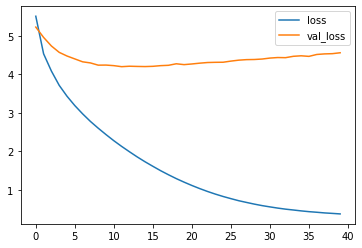

In [31]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

O descolamento das curvas indica certo grau de overfitting do modelo.
- Isto pode ter sido causado por um número reduzido de dados de treinamento, já que limitamos as amostras pela definição do hiperparâmetro `NUM_SAMPLES = 10000`.

## **ATENÇÃO: O primeiro teste de validação de um modelo Machine Learning é a verificação da sua capacidade de realizar sobreajuste.**

### **Um modelo que não é capaz de realizar sobreajuste (memorização) em geral não possui complexidade suficiente para representar os dados, resultando no problema oposto (underfitting).** 

- Após a verificação da possibilidade de sobreajuste, devemos refinar o modelo para eliminar o overfitting.
- Assim, neste caso, **o overfitting é positivo em um primeiro momento por demonstrar a viabilidade do modelo proposto e comprovar a possibilidade de realizar traduções**.

# **Plotar gráfico da precisão**

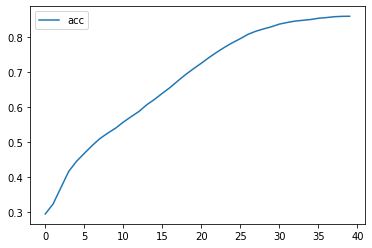

In [32]:
# accuracies
#plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['acc'], label='acc')

#plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Repare que, caso não estivéssemos utilizando as métricas criadas como funções, deveríamos utilizar as linhas marcadas como comentários.

Porém, como visto no language modelling (geração de poemas), seria necessário realizar o encoding completo dos dados.

# **Utilização do modelo para realizar tradução**

# **Construção do segundo modelo para o decoder**

Em Keras, precisamos especificar também os comprimentos das sequências ou séries temporais.
- Para o treinamento, o tamanho do input será simplesmente o comprimento da sequência mais longa a ser processada.
  - No treinamento (sistema encoder), nós alimentamos a rede com a sequência de input (frase) completa, e obtemos uma previsão para a palavra seguinte - tudo isto ocorre simultaneamente.
- Para os testes e previsões (sistema decoder), o tamanho do input é diferente. Nós só podemos passar uma palavra por vez, pois precisamos usar cada previsão como input da unidade recursiva seguinte.
  - Precisamos, então, construir um novo modelo, com novas entradas e novos tamanhos.


In [33]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

Aqui temos o modelo do decoder, no qual:
- A alimentação `Input` possui tamanho = 1 (ou seja, são **sequências formadas por uma única palavra ou token**);
- São utilizadas **exatamente as mesmas camadas definidas para o modelo de encoding** (os dois sistemas devem utilizar a mesma estrutura de redes neurais);
  - Caso fossem criadas novas camadas, haveria novos pesos aleatórios. Desejamos utilizar a mesma estrutura obtida para os dados de treinamento (encoder), incluindo os pesos já treinados.

### **Como usaremos os pesos treinados para o encoder, o processo de treinamento não é repetido para o decoder. Simplesmente aplicamos os novos inputs e tamanhos à estrutura de redes neurais já desenvolvida e treinada, gravada como `Model`.**

- Este o motivo pelo qual o argumento `return_states = True` ter sido fornecido durante a definição do LSTM: embora os estados não fossem necessários para o sistema de encoding (foram, inclusive, ignorados), precisamos dos valores deles para o sistema de decoding.
- Isso porque, como visto, cada unidade LSTM requer 3 inputs:
  - Vetor de palavras obtido como saída da unidade LSTM anterior ("current word vector");
  - Hidden state anterior ("previous hidden state"), saída da unidade anterior;
  - Cell state anterior ("previous cell state"), saída da unidade anterior.

Repare que só passamos os valores de estado z = 0 como estados iniciais no language modelling, mas isto não ocorre para a tradução.

Ao evocar o modelo com os parâmetros já treinados, estamos de certa forma aplicando ele manualmente. De fato, o código acima força Keras **a aplicar o modelo `Model` já obtido por teacher forcing para gerar as saídas (nova sequência de palavras)**.
- Para o sistema de encoding, quando treinamos as redes neurais, Keras realizou simultânea e automaticamente o ajuste dos parâmetros e o cálculo das saídas do modelo.

### **O array `encoder_states` armazenará os valores dos estados `h, c`.**

# **Saída do modelo**

In [34]:
# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

O novo modelo correspondente ao decoder e que utiliza a mesma estrutura de camadas que o modelo anterior é chamado `decoder_model`:

```
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)
```


Repare que os comentários indicam os estados e valores de entrada e saída, bem como como seria o código para a arquitetura GRU.

Repare também em `output` que são retornados: 
- `decoder_outputs`: enquanto Scikit-learn retorna a classe prevista, e é preciso solicitar expressamente o retorno das probabilidades, **Keras retorna diretamente as probabilidades associadas a cada classe**. Assim, `decoder_outputs` será o vetor de probabilidades associado à palavra seguinte, a partir do qual se conhece a palavra de maior probabilidade.
- o hidden state `h` e o cell state `c` são novamente retornados, de modo que eles podem ser utilizados como a alimentação da unidade LSTM seguinte.

Como visto, cada unidade LSTM requer estes três parâmetros de entrada, a saída e os estados da unidade anterior.

In [35]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

O modelo de redes neurais retornará apenas valores numéricos, os quais correpondem aos índices das palavras. 
- Precisamos, portanto, criar um mapeamento índice-palavras (i.e., informar a quais palavras correspondem cada um dos índices retornados).
- Isto permitirá que o modelo retorne sequências contendo palavras (sentenças).

### **O dicionário `idx2word_trans`, portanto, correlaciona os índices numéricos a cada uma das possíveis palavras de saída traduzidas (translated)**.

Assim, após as redes neurais retornarem um valor numérico, o algoritmo acessará este dicionário para coletar a palavra seguinte da sentença gerada.

# **Função `decode_sequence`**

Esta função gerará a sentença traduzida, dada uma sentença de input.

- No início desta função, encontramos os inputs do modelo. Eles são localizados por meio do token sinalizador de início da sentença, `'<sos>'`. Na linha abaixo, vemos que o token de início da sentença é efetivamente tomado como a primeira palavra:
```
target_seq[0, 0] = word2idx_outputs['<sos>']
```
Note que armazenamos as palavras em arrays 1x1: isto porque temos uma única palavra amostrada e, como visto, utilizamos sentenças formadas por uma única palavra no decoder.

Como visto, a definição dos estados iniciais iguais a zero tanto no encoder quanto no decoder é uma particularidade do Language Modelling. **Em Seq2Seq (para tradução, por exemplo), os estados iniciais do decoder são os estados de saída do encoder**.

Na sequência, a função localiza o token sinalizador de fim da sentença, de modo a saber onde parar:

```
eos = word2idx_outputs['<eos>']
```
Ou o algoritmo parará ao encontrar `'<eos>'`, ou ao atingir o parâmetro `max_len_target` (dependendo de qual for alcançado antes).

Na sequência, é criada uma lista para armazenar as palavras geradas, antes de iniciar o loop principal:

```
output_sentence = []
```



In [36]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

A primeira ação do loop é realizar uma previsão, retornando os valores de output `output_tokens`, de hidden state `h` e de cell state `c` dada uma sequência de target e os valores de estado.

```
output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
```
O parâmetro `o` será uma lista de probabilidades para a próxima palavra, de onde tiraremos a próxima palavra amostrada.

Repare que as nomenclaturas `h, c` são as mesmas na alimentação e na saída da função. Portanto, os estados `h, c` obtidos serão usados como input do método `predict` da iteração seguinte.

O próximo passo do loop consiste na escolha da palavra seguinte a ser gerada pelo poema.

Em alguns casos, o algoritmo pode retornar uma alta probabilidade para o índice 0, o que não faz sentido, já que, nesta situação, Keras inicia a indexação das palavras em 1, como visto. Assim, um alerta é gerado caso isto ocorra. **Em geral, este problema é resolvido aumentando-se o tempo de treinamento (aumentando-se a quantidade de epochs)**.

`OBS: estamos nos referindo aqui à indexação do dicionário word2vec, que contém os word embeddings já treinados para conversão de palavras em vetores numéricos. Este dicionário foi utilizado no início do notebook para construção da matriz de embedding.`

### **O segundo dicionário de mapeamento criado (`idx2word_transd`), que correlaciona os índices numéricos a cada uma das possíveis palavras de saída é empregado para retornar a palavra correta**:

```
output_sentence.append(word)
```
A palavra traduzida (elemento) é adicionada à lista `output_sentence` por meio do método `.append` (apêndice do elemento ao fim da lista).

Lembrando que os parâmetros de entrada da próxima unidade LSTM são os valores `target_seq[0, 0]`, e os valores retornados `o, h`, **a função deve atualizar o valor `np_input` para a próxima iteração**. Ele é atualizado com o índice `idx` do dicionário `idx2word` correspondente à palavra escolhida pela unidade anterior para compor a sentença:

```
target_seq[0, 0] = idx
```

# **Método `.join`: concatenação de espaço em branco**

Como as palavras devem ser separadas por espaços em branco, concatenamos uma string formada apenas por um espaço em branco ao início de cada uma das palavras da lista `output_sentence`. A função retorna esta lista, formada por strings contendo um espaço em branco + (palavra de saída escolhida).
```
return ' '.join(output_sentence)
```
- Ao concatenar-se cada um dos elementos desta lista, será gerada uma frase na qual as palavras estarão devidamente separadas por espaços em branco.
- O método `string.join(list)` automaticamente concatena a string `string` à esquerda de cada elemento da lista de input `list` fornecida como argumento.




### **Uma diferença importante em relação ao language modelling é que aqui nós tomamos o máximo de probabilidade, ao invés de tomar um valor da distribuição estatística das frases possíveis**.
- Isso porque desejamos a tradução mais precisa possível, não um novo poema.

In [37]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I do my best.
Translation: eu fiz o que posso.
Continue? [Y/n]Y
-
Input: Don't come in.
Translation: não entre.
Continue? [Y/n]Y
-
Input: I miss college.
Translation: eu gosto de meninas.
Continue? [Y/n]Y
-
Input: Tom's coming.
Translation: tom está vindo.
Continue? [Y/n]Y
-
Input: I love Mary.
Translation: eu amo maria.
Continue? [Y/n]Y
-
Input: We're working.
Translation: estamos trabalhando.
Continue? [Y/n]Y
-
Input: Keep cool.
Translation: fique com a chaves.
Continue? [Y/n]Y
-
Input: Call home!
Translation: liguem para casa, senhores!
Continue? [Y/n]Y
-
Input: Tom is witty.
Translation: tom é espirituoso.
Continue? [Y/n]Y
-
Input: I want to play.
Translation: eu quero muito.
Continue? [Y/n]Y
-
Input: Is it all over?
Translation: está tudo acabado.
Continue? [Y/n]n


A condição

```
while True:
```
Cria um loop que se repete infinitamente, até que o usuário digite 'n', única situação que o interrompe com o comando break.


Um teste interessante para a validação do modelo é utilizar o Google Translator para traduzir as sentenças obtidas novamente para a língua original, e checar a correspondência.
- Esta estratégia é particularmente útil caso seja necessário criar um tradutor para uma língua que não se conhece.

Em alguns casos, a tradução reversa pode resultar em uma sentença semelhante, mas não exatamente igual.
- Isto mostrará que o modelo aprendeu a não realizar uma simples tradução palavra a palavra, **mas que efetivamente aprendeu o significado das palavras e expressões**.

# **Função `numpy.random.choice`**

A função numpy.random.choice escolhe um valor aleatório dentro do intervalo especificado. Assim, ao evocarmos

```
np.random.choice(len(input_texts))
```
Estamos selecionando aleatoriamente um valor inteiro dentro do intervalo [0, len(input_texts) ), ou seja, um valor entre zero e len(input_texts) - 1.

Este valor será um dos índices da lista input_texts, que nada mais é que a primeira coluna do dicionário que utilizamos para treinamento.

A seguir, utilizamos este índice para selecionar uma sentença já convertida em vetor de palavras. Esta sentença é que será traduzida:

```
input_seq = encoder_inputs[i:i+1]
```
Naturalmente, poderíamos utilizar o modelo para traduzir novas sentenças. Bastaria converter estas novas sentenças nos vetores de palavras e utilizá-las como alimentação da função.


# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.